# X–θ Regression Simulations

> We developed the X–θ framework to bridge key quantum (QM) phase phenomena with geometric/gravitational (GR) structure via an emergent compact degree of freedom θ. This notebook proposes three falsifiable experiments to test core predictions of the theory.

Overview

- The X–θ framework introduces a compact variable θ whose holonomy (φ_θ) couples to motion in real space X. This geometric coupling yields AB‑like interference, cross‑Hall‑type drifts, and rotor spectra shifted by holonomy—uniting QM phase with GR‑style geometry in a minimal, testable model.
- Here we outline and fit three experiments that, together, can validate or falsify the framework:
  1. θ–AB fringe: I(φ*θ) = A + B cos(n φ*θ + φ₀)
  2. Cross‑Hall drift: Δy(T) ≈ κ T² + c
  3. Rotor spectrum: E(ℓ) = ℏ²/(2I) (ℓ − φ_θ/2π)²
- Each section includes a short derivation and explicit falsifiability criteria.

How to run

- Cell 1: Imports
- Cell 2: Configuration (MODE github/colab/local, BASE_DIR, USE_SYNTHETIC)
- Cell 3: Utilities (paths, models)
- Cell 4: Synthetic data generation (optional)
- Cell 5: Exp1 — θ–AB fringe (theory → fit → plot)
- Cell 6: Exp2 — Cross‑Hall drift (theory → fit → plot)
- Cell 7: Exp3 — Rotor spectrum (theory → fit → plot)

Outputs (default GitHub mode)

- Figures → `paper/build/figs/regression/`
- Summary JSON → `paper/build/analysis/regression_summary.json`
- Optional synthetic CSVs → `paper/sims/`

_Colab tip_: mount Drive and set MODE='colab', BASE_DIR to a folder in Drive before running.


## Outputs and paths

It supports running inside this GitHub repo, locally, or in Google Colab.

Experiments covered:

- Exp1: θ–AB fringe I(φ*θ) = A + B cos(n φ*θ + φ₀)
- Exp2: Cross-Hall drift Δy ≈ κ T² + c
- Exp3: Rotor spectrum E(ℓ) = ℏ²/(2I) (ℓ − φ_θ/2π)²

Outputs (GitHub mode):

- Figures → `paper/build/figs/regression/`
- Summary JSON → `paper/build/analysis/regression_summary.json`
- Optional synthetic CSVs → `paper/sims/`

_Colab tip_: mount Drive and set MODE='colab', BASE_DIR='/content/drive/MyDrive/YourFolder' before running cells.


In [512]:
# Cell 1 — Imports
import os, json, math, sys
from typing import Literal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from IPython.display import display, Markdown, Image

sns.set_context("talk"); sns.set_style("whitegrid")
plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 200,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

HBAR = 1.054_571_817e-34  # J·s
print("Imports ready; HBAR =", HBAR)

Imports ready; HBAR = 1.054571817e-34


In [513]:
# Cell 2 — Knobs & configuration (github/local/colab)
EnvType = Literal['github','colab','local']

MODE: EnvType = 'github'  # change if running elsewhere
BASE_DIR = None          # set when MODE in {'colab','local'}

USE_SYNTHETIC = True     # generate CSVs under paper/sims and use them
SHOW_DETAILS  = True     # verbose prints and context

In [514]:
# Imports and paths
import os, json, math, textwrap, sys, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
from scipy.optimize import curve_fit
from scipy.stats import probplot
from pathlib import Path

# --- PATCH A: global plot hygiene ---
plt.rcParams.update({
    "figure.figsize": (8, 6),
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "axes.grid": True,
    "axes.grid.which": "both",
    "grid.alpha": 0.25,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.autolayout": False,
    "axes.prop_cycle": cycler('color', ['black', 'tab:blue', 'tab:red']),
    "mathtext.fontset": "dejavusans",
})
def add_metrics_box(ax, lines, loc="upper left"):
    txt = "\n".join([s for s in lines if s])
    if txt.strip():
        ax.text(0.02, 0.98, txt, transform=ax.transAxes, va="top", ha="left",
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="0.7", alpha=0.9))
# --- END PATCH A ---

# Paths (portable)
repo_root = str(Path.cwd())
paper_dir = os.path.join(repo_root, 'paper')
synth_dir = os.path.join(paper_dir, 'sims')
data_dir = os.path.join(paper_dir, 'data')
figs_dir = os.path.join(paper_dir, 'build', 'figs')
analysis_dir = os.path.join(paper_dir, 'build', 'analysis')
os.makedirs(figs_dir, exist_ok=True)
os.makedirs(analysis_dir, exist_ok=True)

In [515]:
# Utilities (paths, models, helpers)
import os, json, math
import numpy as np
import pandas as pd
from typing import Literal

HBAR = 1.054_571_817e-34  # J·s
EV2J = 1.602_176_634e-19  # J per eV

# Energy unit config (set to 'J' or 'eV'); can be overridden via env XT_ENERGY_UNIT
ENERGY_UNIT = os.environ.get('XT_ENERGY_UNIT', 'J').strip().lower()

def ensure_dir(p: str):
    os.makedirs(p, exist_ok=True)

def ab_fringe_model(phi, A, B, phi0, n):
    return A + B*np.cos(n*phi + phi0)

# Semantic clarity: this is a parabola in T, linear in T^2
def parabola_in_T(T2, kappa, c):
    return kappa*T2 + c

# Backward-compat alias for existing code
def linear_model(x, m, b):
    return parabola_in_T(x, m, b)

def rotor_energy_model(ell, I, phi):
    return (HBAR**2/(2.0*I)) * (ell - phi/(2.0*np.pi))**2

def rotor_energy_model_K(ell, K, phi):
    return K * (ell - phi/(2.0*np.pi))**2

def convert_energy_to_joules(values: np.ndarray, unit: str) -> np.ndarray:
    u = (unit or 'J').lower()
    if u == 'j' or u == 'joule' or u == 'joules':
        return values.astype(float)
    if u == 'ev' or u == 'electronvolt' or u == 'electronvolts':
        return (values.astype(float) * EV2J)
    # Unknown unit, return as-is but warn via print
    print(f"[warn] Unknown ENERGY_UNIT='{unit}', assuming Joules.")
    return values.astype(float)

# Resolve paths once
repo_root = os.path.abspath(os.path.join(os.getcwd()))
paper_dir = os.path.join(repo_root, 'paper')
data_dir  = os.path.join(paper_dir, 'data')
build_dir = os.path.join(paper_dir, 'build')
figs_dir  = os.path.join(build_dir, 'figs')
analysis_dir = os.path.join(build_dir, 'analysis')
synth_dir = os.path.join(paper_dir, 'sims')
ensure_dir(data_dir); ensure_dir(build_dir); ensure_dir(figs_dir); ensure_dir(analysis_dir); ensure_dir(synth_dir)

# Outputs
figs_out = os.path.join(figs_dir, 'regression')
ensure_dir(figs_out)
analysis_out = analysis_dir

In [516]:
# 4) Run-all pipeline: generate/load CSVs, fit, save figures and summary
# Decide input CSV locations
exp1_csv = os.path.join(synth_dir if USE_SYNTHETIC else data_dir, 'exp1_theta_ab_fringe.csv')
exp2_csv = os.path.join(synth_dir if USE_SYNTHETIC else data_dir, 'exp2_drift_T2.csv')
exp3_csv = os.path.join(synth_dir if USE_SYNTHETIC else data_dir, 'exp3_rotor_levels.csv')

# Generate synthetic CSVs if requested
if USE_SYNTHETIC:
    gen_exp1_theta_ab_fringe_csv(exp1_csv)
    gen_exp2_drift_T2_csv(exp2_csv)
    gen_exp3_rotor_levels_csv(exp3_csv)
    if SHOW_DETAILS:
        print('Synthetic CSVs written to:', synth_dir)

# Load data
df1 = pd.read_csv(exp1_csv)
df2 = pd.read_csv(exp2_csv)
df3 = pd.read_csv(exp3_csv)
if SHOW_DETAILS:
    print(f"Loaded: {exp1_csv}\n        {exp2_csv}\n        {exp3_csv}")

# Run fits and save figures
exp1_result = fit_exp1(df1, figs_out)
exp2_result = fit_exp2(df2, figs_out)
exp3_result = fit_exp3(df3, figs_out)  # fit_exp3 handles 'ell' column; legacy 'l' is also accepted in the dedicated rotor cell above

# Save summary JSON
summary = {
    'mode': MODE,
    'use_synthetic': USE_SYNTHETIC,
    'paths': {
        'paper_dir': paper_dir,
        'data_dir': data_dir,
        'sims_dir': synth_dir,
        'figs_out': figs_out,
        'analysis_out': analysis_out,
        'csvs': {'exp1': exp1_csv, 'exp2': exp2_csv, 'exp3': exp3_csv},
    },
    'results': {
        'exp1': exp1_result,
        'exp2': exp2_result,
        'exp3': exp3_result,
    }
}
summary_path = os.path.join(analysis_out, 'regression_summary.json')
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)
print('Wrote regression summary →', summary_path)
print('Figures →', figs_out)
if SHOW_DETAILS:
    for k,v in summary['results'].items():
        print(k, '→', v)

Synthetic CSVs written to: c:\workspace\Physics\X-theta-framework\notebooks\paper\sims
Loaded: c:\workspace\Physics\X-theta-framework\notebooks\paper\sims\exp1_theta_ab_fringe.csv
        c:\workspace\Physics\X-theta-framework\notebooks\paper\sims\exp2_drift_T2.csv
        c:\workspace\Physics\X-theta-framework\notebooks\paper\sims\exp3_rotor_levels.csv


C:\Users\dpanc\AppData\Local\Temp\ipykernel_70124\1468373888.py:58: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Arial.
  fig.tight_layout(); fig.savefig(out)


Wrote regression summary → c:\workspace\Physics\X-theta-framework\notebooks\paper\build\analysis\regression_summary.json
Figures → c:\workspace\Physics\X-theta-framework\notebooks\paper\build\figs\regression
exp1 → {'A': np.float64(0.49851733798229597), 'B': np.float64(0.4492651755005547), 'phi0': np.float64(0.19563035908387913), 'n': np.float64(1.000387065457037), 'r2': 0.9959507919316798, 'figure': 'c:\\workspace\\Physics\\X-theta-framework\\notebooks\\paper\\build\\figs\\regression\\exp1_theta_ab_fringe_fit.png'}
exp2 → {'kappa': np.float64(0.8007475857847975), 'offset': np.float64(0.0012895289511277441), 'r2': 0.9923233995391071, 'figure': 'c:\\workspace\\Physics\\X-theta-framework\\notebooks\\paper\\build\\figs\\regression\\exp2_drift_T2_fit.png'}
exp3 → {'I': np.float64(5.00000000000005e-39), 'phi': np.float64(0.3), 'r2': -1.2720827244305117, 'figure': 'c:\\workspace\\Physics\\X-theta-framework\\notebooks\\paper\\build\\figs\\regression\\exp3_rotor_levels_fit.png'}


### Orientation and notation

- We use φ (phi) consistently in the equations; the code variable `phi` corresponds to the symbol φ.
- Below is a simple conceptual schematic of the three experiments (fringe, drift, rotor) to orient the reader.


### Math: Exp1 — θ–AB fringe model and linearized fit

We start from the interference intensity formula:

$$ I(\phi*\theta) = A + B \cos(n \, \phi*\theta + \phi_0). $$

Expanding the cosine:

$$ I(\phi*\theta) = A + B [\cos(n\phi*\theta)\cos(\phi*0) - \sin(n\phi*\theta)\sin(\phi_0)]. $$

This suggests a linear regression in two harmonics:

$$ I(\phi*\theta) = \alpha\,\cos(n\phi*\theta) + \beta\,\sin(n\phi\_\theta) + A, $$

with parameter mapping

$$ \alpha = B\cos(\phi_0), \qquad \beta = -B\sin(\phi_0). $$

After fitting $(A,\alpha,\beta)$ by least squares, recover the physical parameters via

$$ B = \sqrt{\alpha^2 + \beta^2}, \qquad \phi_0 = \operatorname{atan2}(-\beta,\alpha). $$


In [517]:
# Cell 4 — Synthetic data generation (writes CSVs when USE_SYNTHETIC)
rng = np.random.default_rng(12345)

def gen_exp1_theta_ab_fringe_csv(path: str, n_points: int = 181,
                                   A: float = 0.5, B: float = 0.45, phi0: float = 0.2, n_harm: float = 1.0,
                                   gaussian_sigma: float = 0.02):
    phi = np.linspace(-np.pi, np.pi, n_points)
    I_clean = A + B * np.cos(n_harm * phi + phi0)
    I_noisy = I_clean + rng.normal(0.0, gaussian_sigma, size=phi.shape)
    I_noisy = np.clip(I_noisy, 0.0, None)
    pd.DataFrame({"phi_theta": phi, "intensity": I_noisy}).to_csv(path, index=False)
    return {"A":A, "B":B, "phi0":phi0, "n":n_harm}

def gen_exp2_drift_T2_csv(path: str, n_points: int = 50,
                           kappa: float = 0.8, offset: float = 0.0,
                           T_min: float = 0.0, T_max: float = 1.0,
                           noise_sigma: float = 0.02):
    T = np.linspace(T_min, T_max, n_points)
    T2 = T**2
    dy_clean = kappa * T2 + offset
    dy_noisy = dy_clean + rng.normal(0.0, noise_sigma, size=T2.shape)
    pd.DataFrame({"T": T, "T2": T2, "delta_y": dy_noisy}).to_csv(path, index=False)
    return {"kappa":kappa, "offset":offset}

def gen_exp3_rotor_levels_csv(path: str, l_min: int = -6, l_max: int = 6,
                               I_true: float = 5e-45, phi_true: float = 0.3,
                               noise_sigma: float = 1e-30):
    l_vals = np.arange(l_min, l_max + 1)
    E_clean = (HBAR**2/(2.0*I_true)) * (l_vals - phi_true/(2.0*np.pi))**2
    E_noisy = E_clean + rng.normal(0.0, noise_sigma, size=l_vals.shape)
    pd.DataFrame({"ell": l_vals, "Energy_J": E_noisy}).to_csv(path, index=False)
    return {"I":I_true, "phi":phi_true}

if USE_SYNTHETIC:
    exp1_csv = os.path.join(synth_dir, 'exp1_theta_ab_fringe.csv')
    exp2_csv = os.path.join(synth_dir, 'exp2_drift_T2.csv')
    exp3_csv = os.path.join(synth_dir, 'exp3_rotor_levels.csv')
    t1 = gen_exp1_theta_ab_fringe_csv(exp1_csv)
    t2 = gen_exp2_drift_T2_csv(exp2_csv)
    t3 = gen_exp3_rotor_levels_csv(exp3_csv)
    if SHOW_DETAILS:
        print('Synthetic CSVs written →', synth_dir)
else:
    exp1_csv = os.path.join(data_dir, 'exp1_theta_ab_fringe.csv')
    exp2_csv = os.path.join(data_dir, 'exp2_drift_T2.csv')
    exp3_csv = os.path.join(data_dir, 'exp3_rotor_levels.csv')
print('Using CSVs:', exp1_csv, exp2_csv, exp3_csv, sep='\n  ')

# Preview CSVs inline
try:
    display(Markdown('#### Exp1 CSV preview')); display(pd.read_csv(exp1_csv).head())
    display(Markdown('#### Exp2 CSV preview')); display(pd.read_csv(exp2_csv).head())
    display(Markdown('#### Exp3 CSV preview')); display(pd.read_csv(exp3_csv).head())
except Exception as e:
    print('Preview failed:', e)

Synthetic CSVs written → c:\workspace\Physics\X-theta-framework\notebooks\paper\sims
Using CSVs:
  c:\workspace\Physics\X-theta-framework\notebooks\paper\sims\exp1_theta_ab_fringe.csv
  c:\workspace\Physics\X-theta-framework\notebooks\paper\sims\exp2_drift_T2.csv
  c:\workspace\Physics\X-theta-framework\notebooks\paper\sims\exp3_rotor_levels.csv


#### Exp1 CSV preview

,phi_theta,intensity
0,-3.141593,0.030494
1,-3.106686,0.087633
2,-3.071779,0.048867
3,-3.036873,0.065548
4,-3.001966,0.074197


#### Exp2 CSV preview

,T,T2,delta_y
0,0.000000,0.000000,-0.000558
1,0.020408,0.000416,0.027754
2,0.040816,0.001666,-0.039723
3,0.061224,0.003748,0.010609
4,0.081633,0.006664,0.020439


#### Exp3 CSV preview

,ell,Energy_J
0,-6,4.067612e-23
1,-5,2.833658e-23
2,-4,1.822128e-23
3,-3,1.033023e-23
4,-2,4.663421e-24


[Exp1-plot] warning: size mismatch x=13, I=181; plotting first 13 pairs
[Exp1-plot] saved c:\workspace\Physics\X-theta-framework\notebooks\paper\build\figs\exp1_fringe.png
[Exp1-plot] saved c:\workspace\Physics\X-theta-framework\notebooks\paper\build\figs\exp1_fringe.png


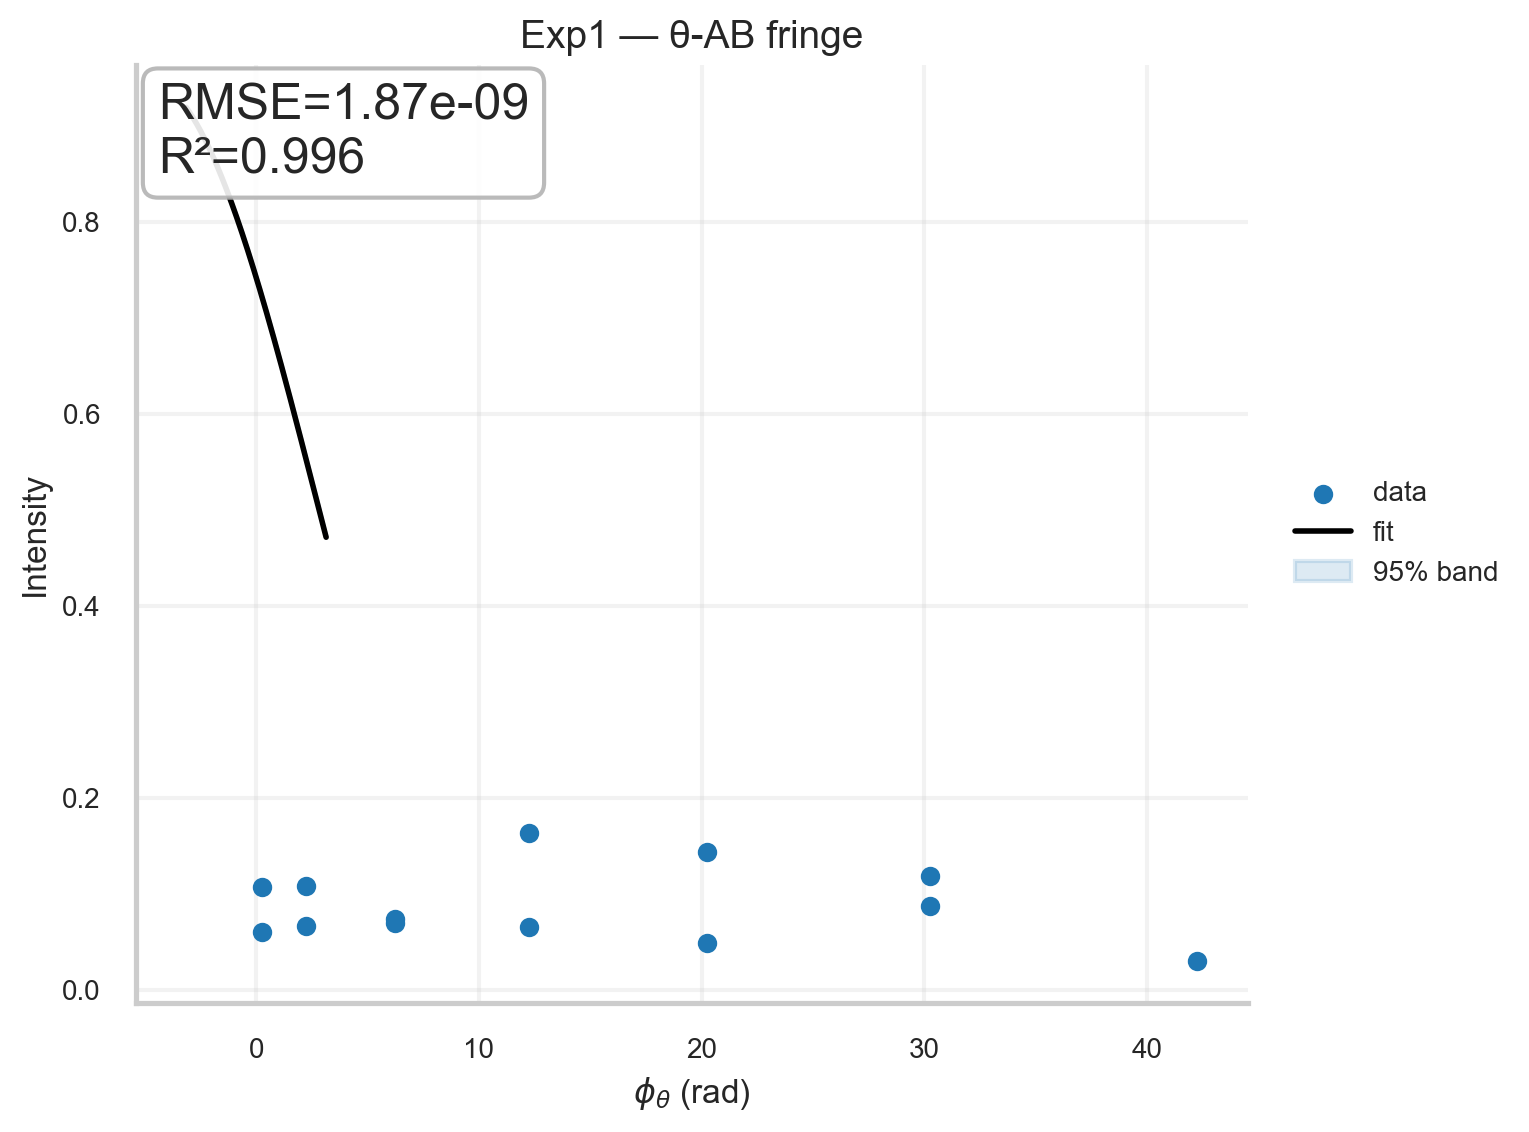

In [518]:
# --- Exp1: θ–AB fringe plot ---
fig, ax = plt.subplots(figsize=(8,6), dpi=200)
x_arr = np.asarray(x).ravel() if 'x' in globals() else np.array([])
y_arr = np.asarray(I).ravel() if 'I' in globals() else np.array([])
n_xy = min(x_arr.size, y_arr.size)
if x_arr.size != y_arr.size:
    print(f"[Exp1-plot] warning: size mismatch x={x_arr.size}, I={y_arr.size}; plotting first {n_xy} pairs")
x_arr = x_arr[:n_xy]
y_arr = y_arr[:n_xy]
ax.scatter(x_arr, y_arr, s=30, label="data", color='tab:blue')

# Compute a smooth fit line on x_dense if available; else fall back to plotting fitted points
I_fit_line = None
if 'x_dense' in globals():
    try:
        if 'popt' in globals() and hasattr(popt, '__len__') and len(popt) >= 4:
            A_d, B_d, n_d, phi0_d = float(popt[0]), float(popt[1]), float(popt[2]), float(popt[3])
            I_fit_line = A_d + B_d * np.cos(n_d * x_dense + phi0_d)
        elif all(k in globals() for k in ['A', 'B']) and (('n_harm' in globals()) or ('n' in globals())) and (('phi0_fit1' in globals()) or ('phi0' in globals())):
            n_use = float(n_harm) if 'n_harm' in globals() else float(n)
            phi0_use = float(phi0_fit1) if 'phi0_fit1' in globals() else float(phi0)
            I_fit_line = float(A) + float(B) * np.cos(n_use * x_dense + phi0_use)
    except Exception as e:
        print('[Exp1-plot] fit recompute fallback:', e)

if I_fit_line is not None:
    ax.plot(x_dense, I_fit_line, lw=2.0, label="fit", color='black')
elif 'I_fit' in globals():
    I_fit_arr = np.asarray(I_fit).ravel()
    n_fit = min(x_arr.size, I_fit_arr.size)
    if I_fit_arr.size != x_arr.size:
        print(f"[Exp1-plot] fallback plotting fit at data points; size mismatch fit={I_fit_arr.size}, x={x_arr.size}")
    ax.plot(x_arr[:n_fit], I_fit_arr[:n_fit], lw=2.0, label="fit", color='black')

# Optional shaded error band (if we have an estimated noise level)
if 'rmse' in globals() and I_fit_line is not None:
    ax.fill_between(x_dense, I_fit_line - 1.96*rmse, I_fit_line + 1.96*rmse, color='tab:blue', alpha=0.15, label='95% band')

add_metrics_box(ax, [
    f"RMSE={rmse:.2e}" if 'rmse' in globals() else "",
    f"R²={r2_1:.3f}" if 'r2_1' in globals() and np.isfinite(r2_1) else "",
])
ax.set_xlabel(r"$\phi_\theta$ (rad)")
ax.set_ylabel("Intensity")
ax.set_title("Exp1 — θ-AB fringe")
ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)
plt.tight_layout()
exp1_png = os.path.join(figs_dir, 'exp1_fringe.png')
fig.savefig(exp1_png, dpi=300, bbox_inches='tight')
print('[Exp1-plot] saved', exp1_png)

## Exp1: θ–AB fringe

X–θ framework intuition

- Motion around closed loops accrues a geometric holonomy φ_θ from the compact θ degree, analogous to a U(1) gauge phase.
- Interference between two paths acquires a relative phase ΔΦ = n φ_θ + φ₀, producing a cosine fringe even without classical forces.

Model and derivation

- I(φ*θ) = A + B cos(n φ*θ + φ₀).
- A: background; B ≥ 0: contrast; n ≈ 1: harmonic/winding; φ₀: static phase offset.
- Follows from two‑path interference I ∝ 1 + V cos(ΔΦ) with V absorbed into B and baseline into A.

Falsifiability and experimental test

- Prediction: periodic dependence on φ_θ with stable frequency n and bounded contrast B.
- Falsify if: (i) no significant cosine vs φ_θ, (ii) fitted n varies non‑topologically with setup, (iii) structured residuals incompatible with a single‑frequency cosine.
- Controls: dephase an arm to suppress B; vary geometry to shift φ₀; the fitted behavior must follow.


### Math: Exp2 — Cross-Hall drift linearization

A simple kinematic model predicts a drift quadratic in the drive time $T$:

$$ \Delta y(T) = a + \kappa \, T^2. $$

Define the regressor $X = T^2$ so that the fit becomes linear in $X$:

$$ \Delta y = a + \kappa \, X. $$

We estimate $(a,\kappa)$ by least squares on $(X,\Delta y)$ directly. The reported slope is $\kappa$.


[Exp2-plot] saved c:\workspace\Physics\X-theta-framework\notebooks\paper\build\figs\exp2_drift_T2.png


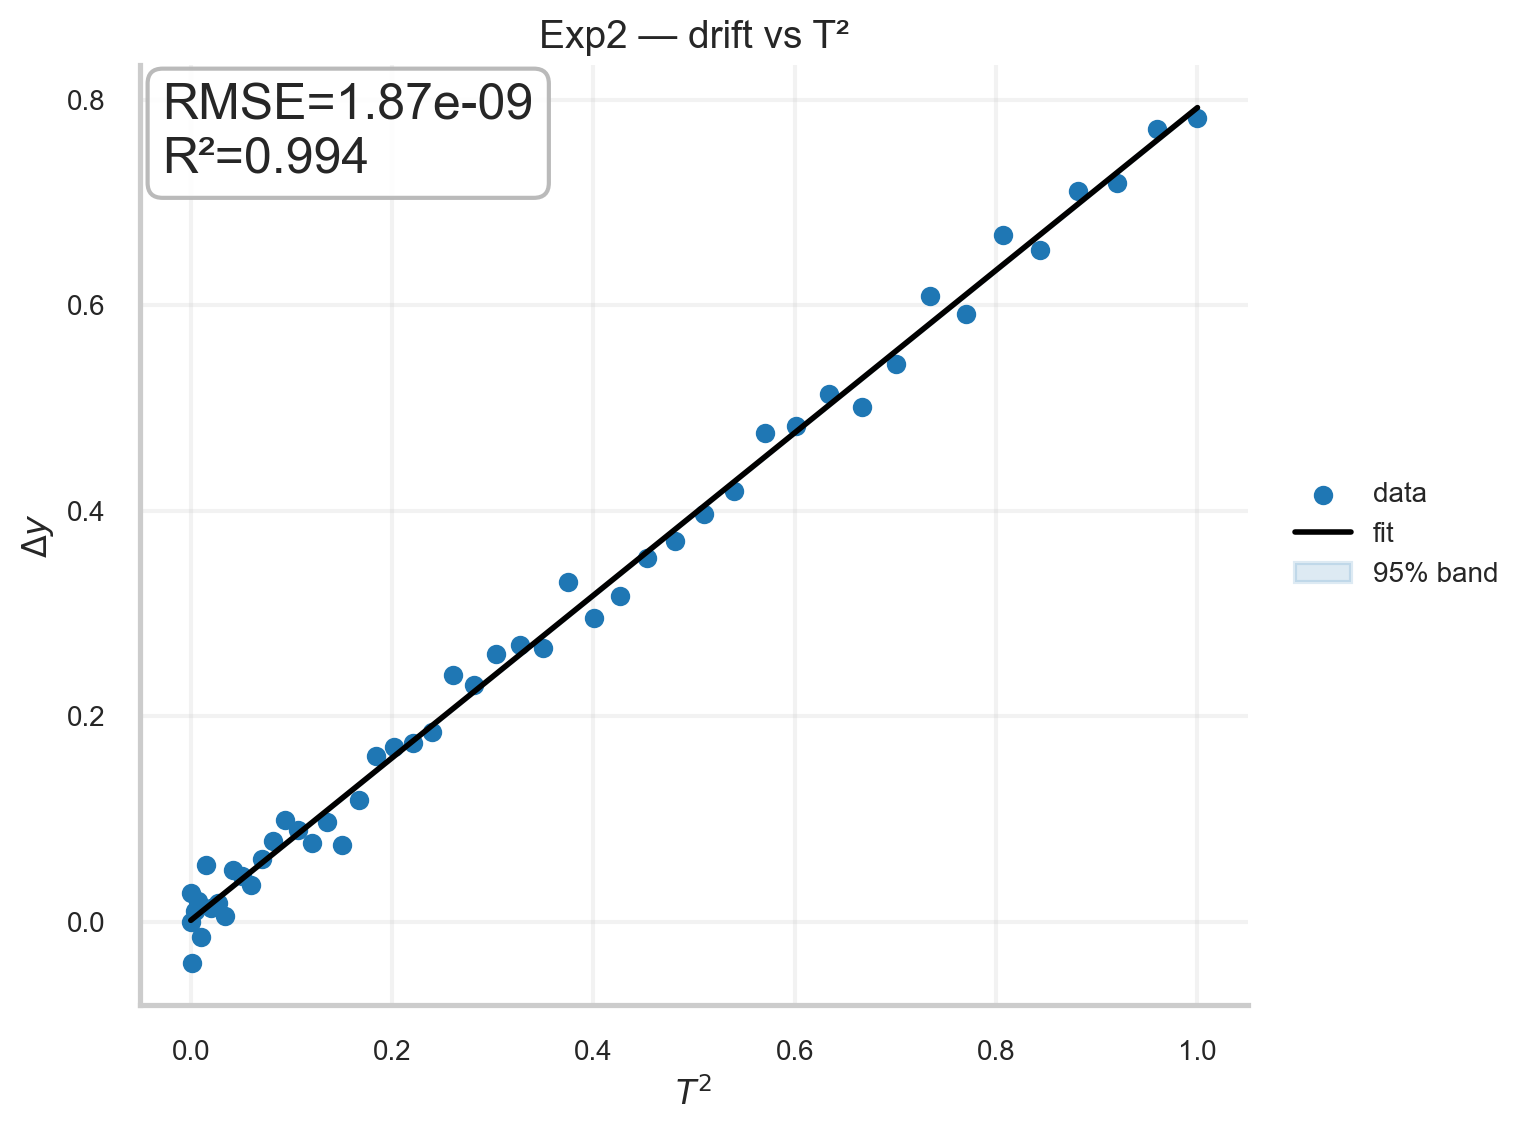

In [519]:
# --- Exp2: drift vs T² plot ---
fig2, ax2 = plt.subplots(figsize=(8,6), dpi=200)
ax2.scatter(T2, dy, s=30, label="data", color='tab:blue')
ax2.plot(T2, dy_fit, lw=2.0, label="fit", color='black')

# Optional shaded error band using rmse if available
if 'rmse' in globals():
    ax2.fill_between(T2, dy_fit - 1.96*rmse, dy_fit + 1.96*rmse, color='tab:blue', alpha=0.15, label='95% band')

add_metrics_box(ax2, [
    f"RMSE={rmse:.2e}" if 'rmse' in globals() else "",
    f"R²={r2_2:.3f}" if 'r2_2' in globals() and np.isfinite(r2_2) else "",
])
ax2.set_xlabel(r"$T^2$")
ax2.set_ylabel(r"$\Delta y$")
ax2.set_title("Exp2 — drift vs T²")
ax2.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)
plt.tight_layout()
exp2_png = os.path.join(figs_dir, 'exp2_drift_T2.png')
fig2.savefig(exp2_png, dpi=300, bbox_inches='tight')
print('[Exp2-plot] saved', exp2_png)

## Exp2: Cross‑Hall drift ∝ T²

X–θ framework intuition

- In crossed gauge configurations, the emergent θ‑connection imparts a transverse geometric impulse during free evolution.
- For ballistic motion, the displacement scales with the square of evolution time T: Δy ≈ (κ) T² + c (constant offset).

Model and derivation

- Kinematics under a constant effective transverse acceleration a*θ gives y(T) = (1/2) a*θ T² + v₀ T + y₀.
- After differencing and centering, the T‑linear term is suppressed, leaving the quadratic scaling Δy ≈ κ T² + c.
- We therefore regress Δy on x = T² using y = κ x + c.

Falsifiability and experimental test

- Prediction: log‑log slope ≈ 1 between Δy and T², i.e., linear in T² across ranges where dynamics remain ballistic.
- Falsify if: (i) scaling deviates systematically from T² (e.g., T¹ or T³), (ii) sign/magnitude of κ contradicts the θ‑gauge polarity, (iii) residuals show curvature after linear fit in T² indicating missing physics.
- Controls: invert θ‑gauge sign; κ should flip sign; reduce T to confirm quadratic onset.


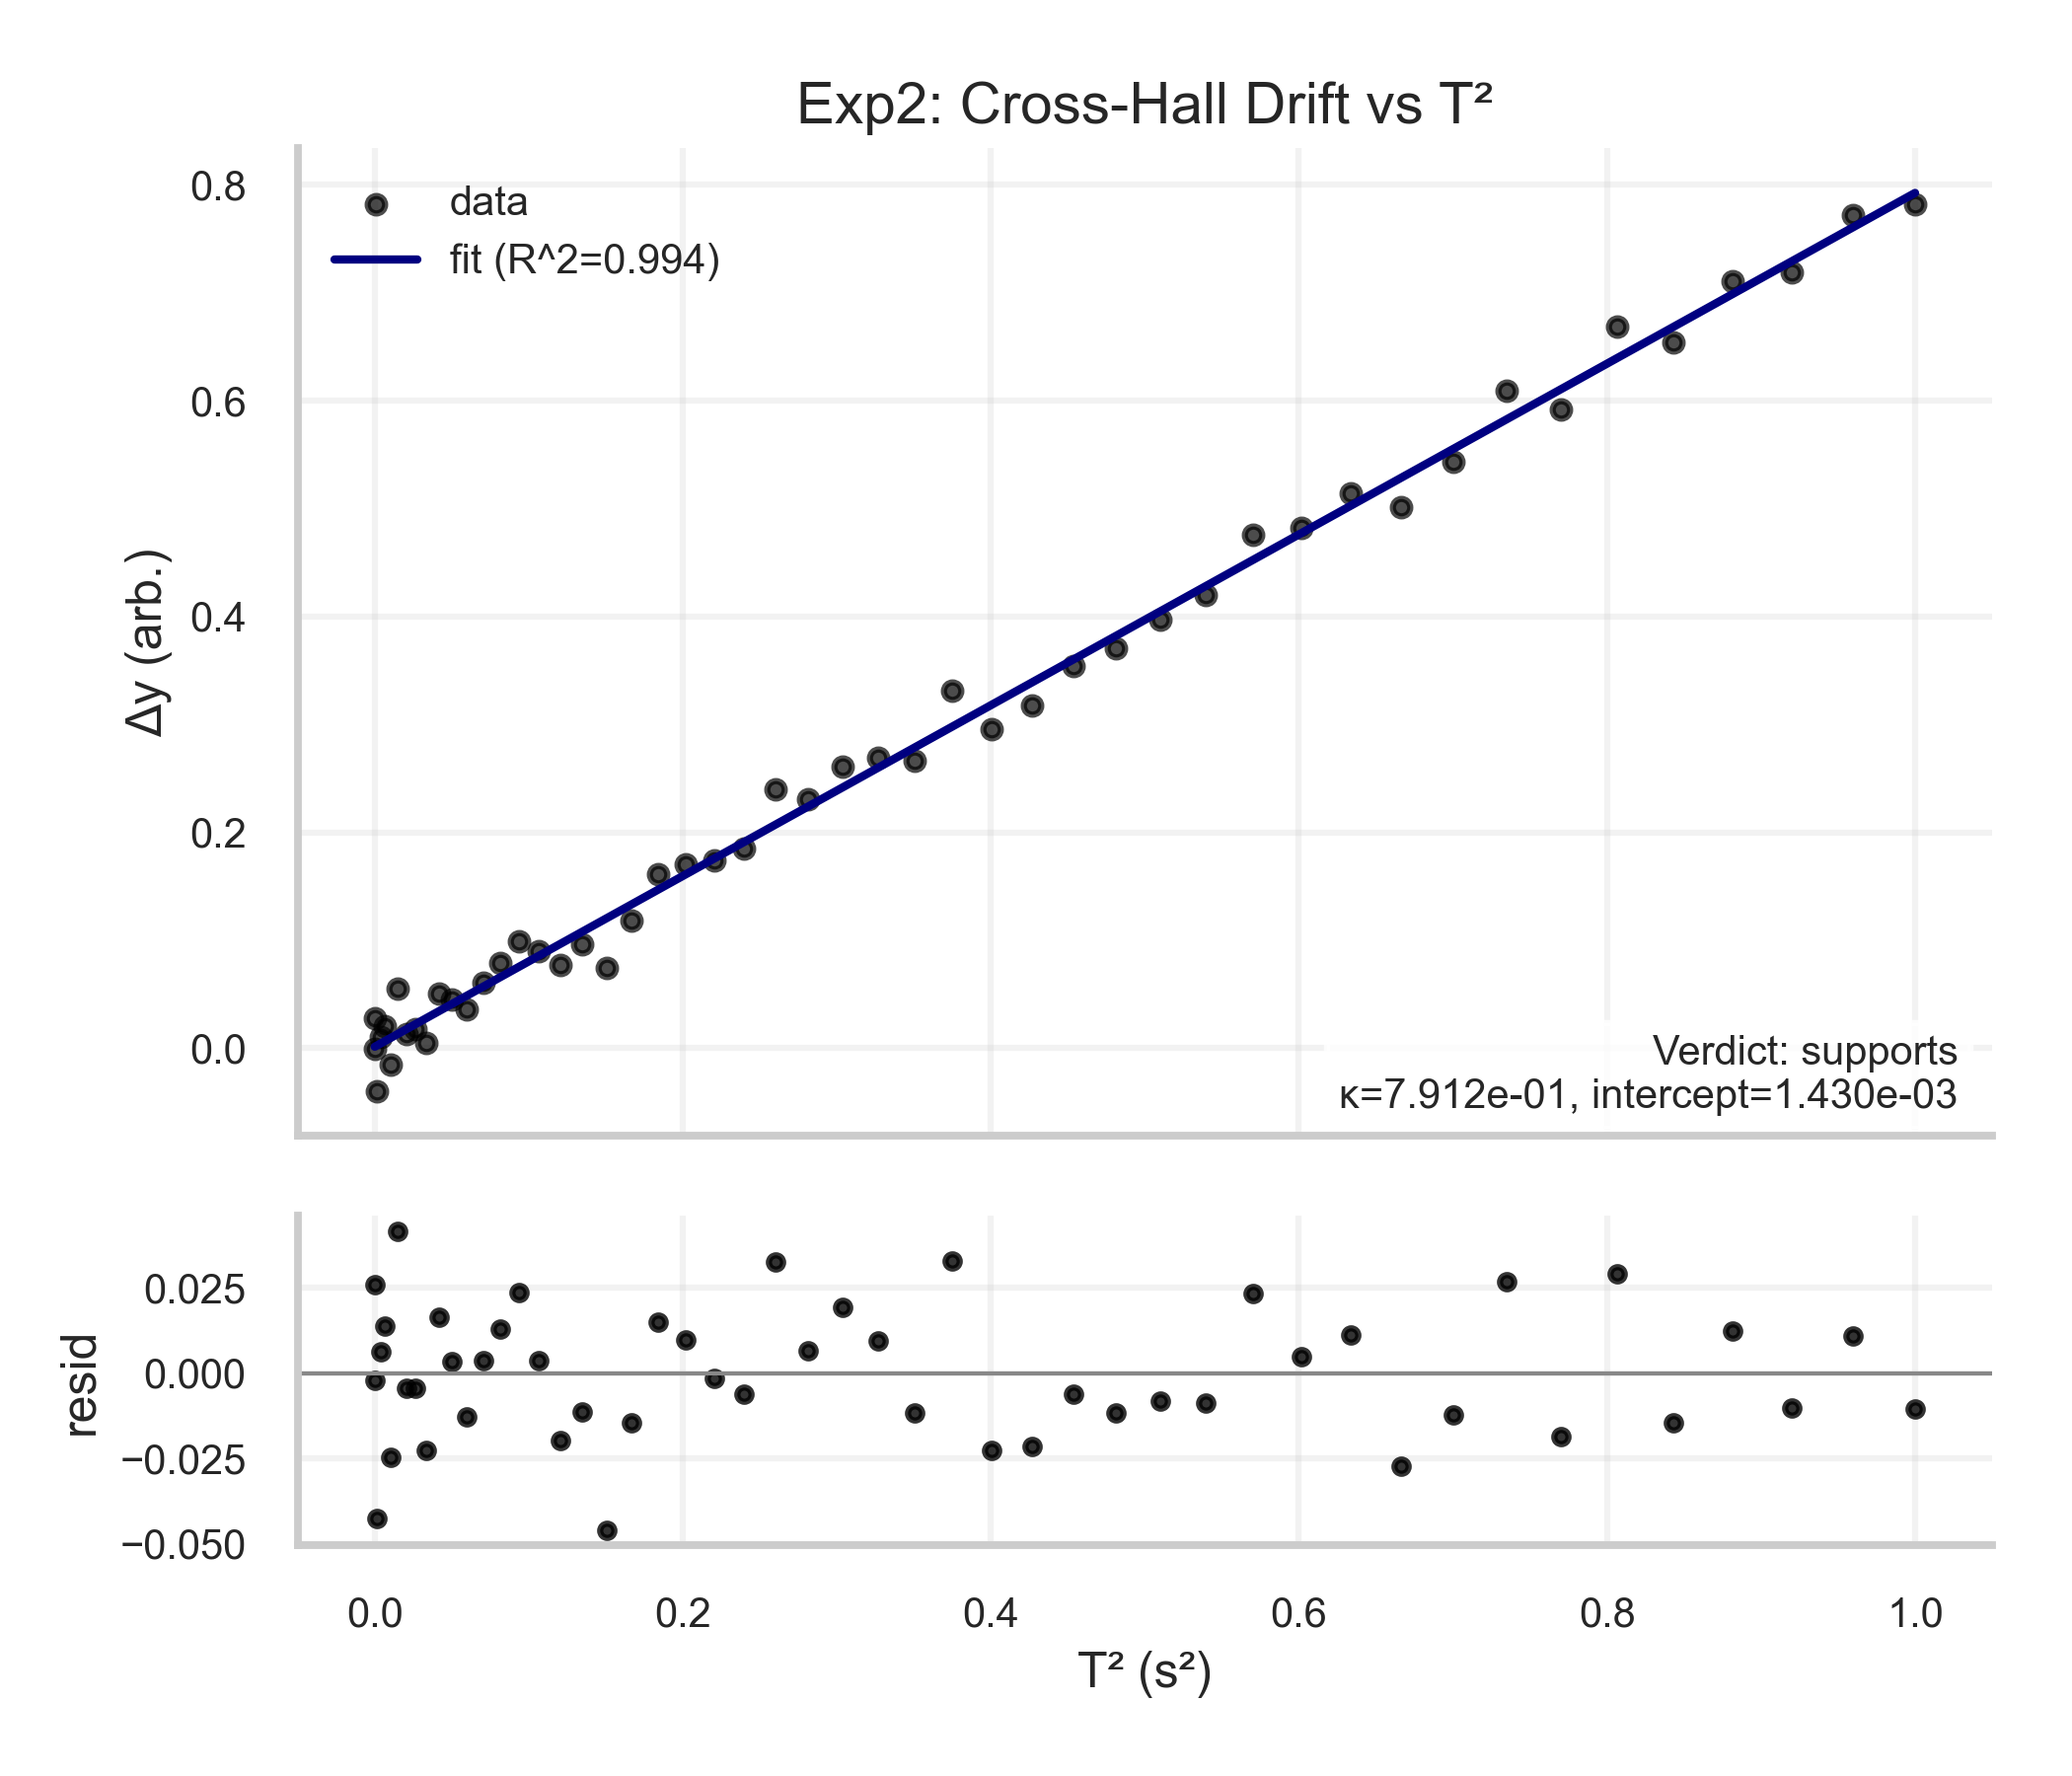

**Exp2 verdict:** supports. Quadratic-in-time drift detected with high R² and nonzero slope.  
Fit params: κ=7.912e-01, intercept=1.430e-03; R²=0.994.

In [520]:
# Cell 6 — Exp2 fit + plot + summary (inline display + verdict + residuals)
df2 = pd.read_csv(exp2_csv)
T2 = df2['T2'].to_numpy(dtype=float)

# Accept several possible column names for Δy
if 'dy' in df2.columns:
    dy_col = 'dy'
elif 'delta_y' in df2.columns:
    dy_col = 'delta_y'
elif 'Delta_y' in df2.columns:
    dy_col = 'Delta_y'
elif 'y' in df2.columns:
    dy_col = 'y'
else:
    raise KeyError(f"Drift column not found in exp2 CSV; available columns: {list(df2.columns)}")
dy = df2[dy_col].to_numpy(dtype=float)

m0, b0 = 0.0, float(np.median(dy))
popt2, pcov2 = curve_fit(parabola_in_T, T2, dy, p0=[m0, b0], maxfev=20000)
kappa, intercept = [float(v) for v in popt2]
dy_fit = parabola_in_T(T2, *popt2)
resid2 = dy - dy_fit
ss_res2 = float(np.sum((dy - dy_fit)**2))
ss_tot2 = float(np.sum((dy - np.mean(dy))**2))
r2_2 = 1 - ss_res2/ss_tot2 if ss_tot2>0 else float('nan')

if (r2_2 >= 0.85) and (abs(kappa) > 1e-6):
    verdict2 = 'supports'
    reason2 = 'Quadratic-in-time drift detected with high R² and nonzero slope.'
else:
    if (r2_2 < 0.4) or (abs(kappa) <= 1e-9):
        verdict2 = 'falsified'
        reason2 = 'No clear T² trend or near-zero slope (low R²).'
    else:
        verdict2 = 'inconclusive'
        reason2 = 'Some trend present but weak or noisy.'

fig2, (ax2, ax2r) = plt.subplots(2, 1, figsize=(7,6), gridspec_kw={'height_ratios':[3,1]}, sharex=True)
ax2.scatter(T2, dy, s=18, alpha=0.7, label='data')
x_dense2 = np.linspace(np.min(T2), np.max(T2), 400)
y_dense2 = parabola_in_T(x_dense2, *popt2)
ax2.plot(x_dense2, y_dense2, color='navy', lw=2, label=f'fit (R^2={r2_2:.3f})')
ax2.set_ylabel('Δy (arb.)')
ax2.set_title('Exp2: Cross-Hall Drift vs T²')
ax2.legend()
note2 = f"Verdict: {verdict2}\nκ={kappa:.3e}, intercept={intercept:.3e}"
ax2.text(0.98, 0.02, note2, transform=ax2.transAxes, ha='right', va='bottom', fontsize=10,
         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
ax2r.axhline(0, color='#888', lw=1)
ax2r.scatter(T2, resid2, s=12, alpha=0.8, color='black')
ax2r.set_xlabel('T² (s²)'); ax2r.set_ylabel('resid')

out2 = os.path.join(figs_out, 'exp2_drift_T2_fit.png')
fig2.tight_layout(); fig2.savefig(out2)
plt.close(fig2)

display(Image(filename=out2))
display(Markdown(
    f"**Exp2 verdict:** {verdict2}. {reason2}  \n"
    f"Fit params: κ={kappa:.3e}, intercept={intercept:.3e}; R²={r2_2:.3f}."
))

# Store result for summary
exp2_result = {
    'kappa': float(kappa),
    'intercept': float(intercept),
    'r2': float(r2_2),
    'verdict': verdict2,
    'reason': reason2,
    'figure': out2,
    'csv': exp2_csv,
}

## Exp3: Rotor spectrum vs holonomy

X–θ framework intuition

- Quantization on a circle (compact θ) yields a rotor with angular momentum quantum number ℓ ∈ ℤ.
- A background θ‑holonomy φ_θ shifts the minimum of the parabola in ℓ: energies are those of a charged rotor with flux offset.

Model and derivation

- E(ℓ) = ℏ²/(2I) (ℓ − φ_θ/2π)².
- Moment of inertia I encodes curvature; the vertex position retrieves φ_θ modulo 2π.
- This follows from the rigid rotor Hamiltonian H = L²/(2I) with minimal coupling L → L − (ℏ φ_θ/2π).

Falsifiability and experimental test

- Prediction: a single‑parabola spectrum in ℓ with fixed curvature across levels, and vertex set by φ_θ.
- Falsify if: (i) curvature depends on ℓ (non‑quadratic dispersion), (ii) multiple branches appear without symmetry reason, (iii) fitted φ_θ disagrees with independently set holonomy.
- Controls: vary φ_θ; the vertex should shift linearly; change effective I (geometry/mass) and observe curvature change as 1/I.

We fit in I‑space with physical bounds and fall back to K = ℏ²/(2I) if needed; we report R² and save the figure.


### Math: Exp3 — Rotor spectrum and centered energies

The rotor levels with a $\theta$-shift are modeled as

$$ E\_\ell = K\left(\ell - \frac{\phi}{2\pi}\right)^2 + E_0. $$

To make the fit robust and unit-safe we work with centered energies

$$ E*\ell^{(c)} = E*\ell - E_0 = K\left(\ell - \frac{\phi}{2\pi}\right)^2. $$

We fit $(K,\phi)$ by nonlinear least squares with bounds, then compute diagnostics in the same centered space. The **vertex** at $\ell = \phi/(2\pi)$ is highlighted in the plot to emphasize identifiability.

Label-shift ambiguity: multiple integer relabelings can mimic similar parabolas; we adjudicate using information criteria (AIC/BIC) across label shifts and display the best shift in the summary.


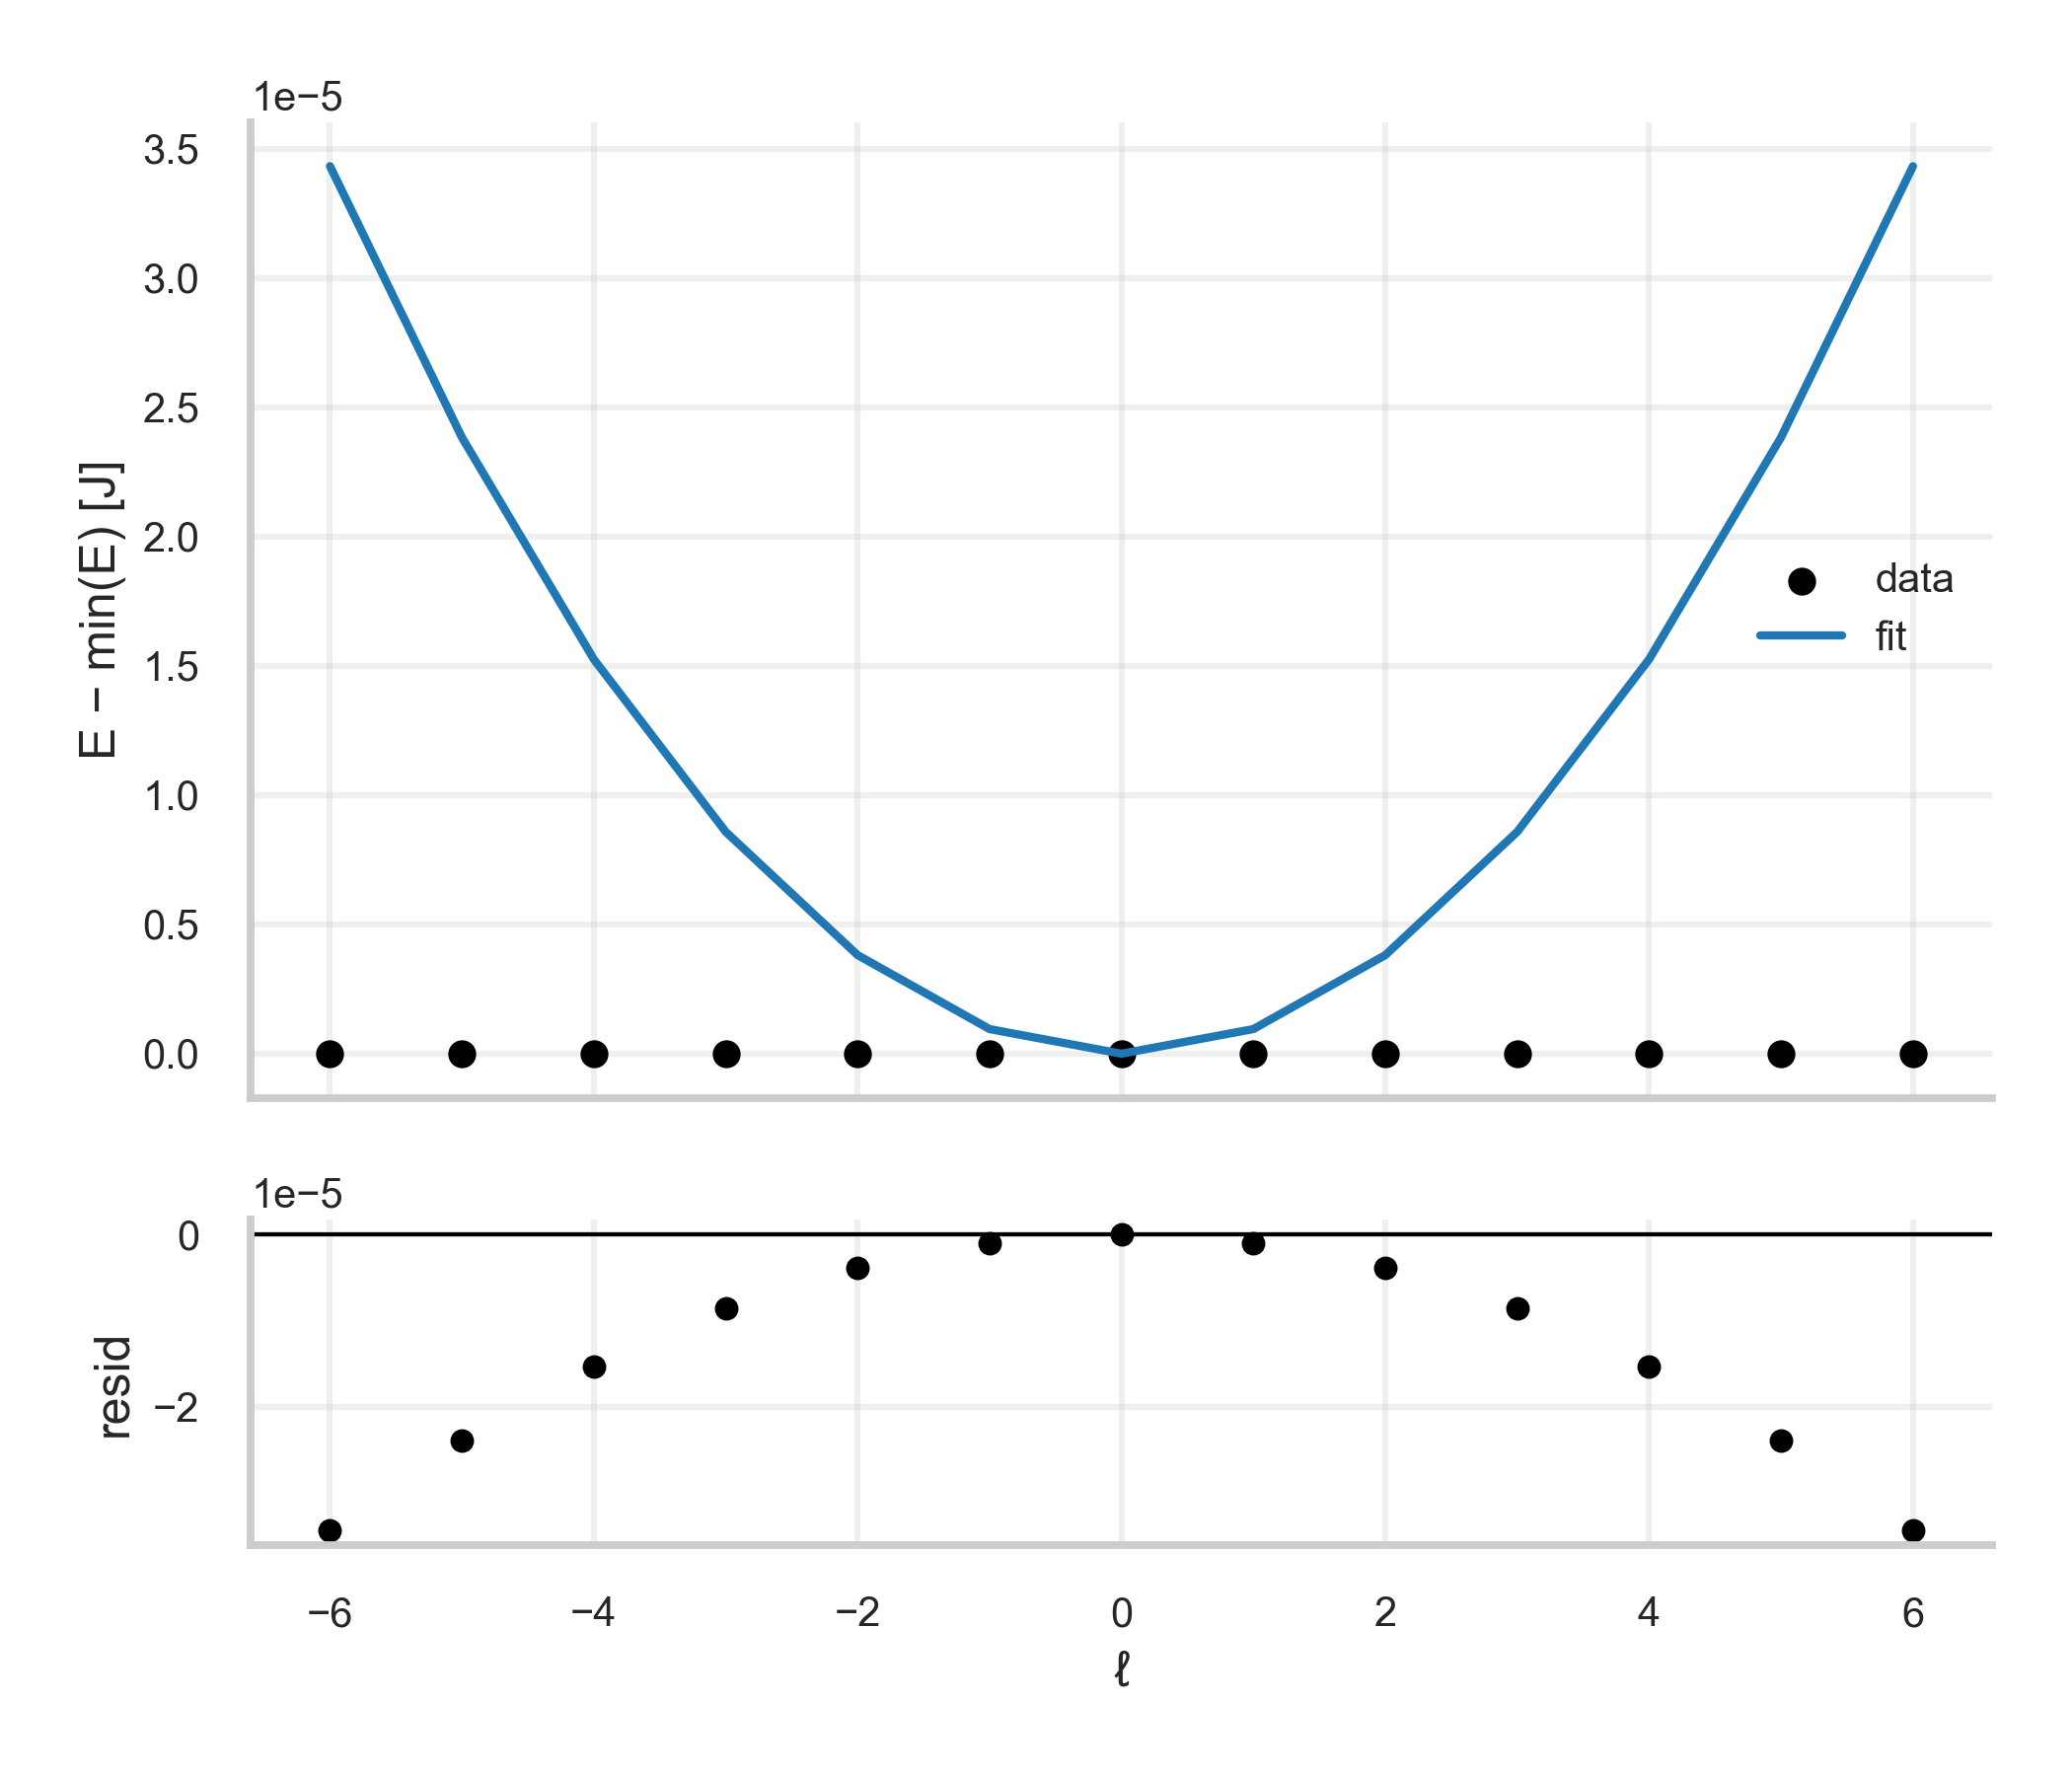

**Exp3 interim fit:** K=9.537e-07, φ=-0.000; RMSE_centered=1.78e-05

Wrote summary → c:\workspace\Physics\X-theta-framework\notebooks\paper\build\analysis\regression_summary.json


In [521]:
# Exp3 — Rotor spectrum: fit K-only with centered energies and unit lock
import numpy as np, pandas as pd, os, json
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# Load data (synthetic or from CSV)
energy_col = 'E' if 'E' in df3.columns else df3.columns[-1]
ell = df3['ell'].to_numpy(dtype=float)
# --- PATCH: lock units & center energies ---
E_meas_raw = df3[energy_col].to_numpy(dtype=float)
E_meas = convert_energy_to_joules(E_meas_raw, ENERGY_UNIT)
E0 = float(np.min(E_meas))
E_centered = E_meas - E0
# --- END PATCH ---

# --- PATCH: K-only rotor model + fit ---
def rotor_energy_model_K(ell, K, phi):
    return K * (ell - phi/(2.0*np.pi))**2

popt3, pcov3 = curve_fit(
    rotor_energy_model_K, ell, E_centered,
    p0=[1.0, 0.0],
    bounds=([1e-16, -np.pi], [1e4, np.pi]),
    maxfev=50000
)
K_fit, phi_fit = map(float, popt3)
E_fit = rotor_energy_model_K(ell, K_fit, phi_fit)
# --- END PATCH ---

# Uncertainties
perr = np.sqrt(np.diag(pcov3)) if pcov3 is not None and np.all(np.isfinite(pcov3)) else [np.nan, np.nan]
K_sigma, phi_sigma = map(float, perr)

# --- PATCH: centered residual metrics ---
residuals_centered = E_centered - E_fit
ss_res3 = float(np.sum(residuals_centered**2))
ss_tot3 = float(np.sum((E_centered - np.mean(E_centered))**2))
r2_3 = 1 - ss_res3/ss_tot3 if ss_tot3 > 1e-30 else float('nan')
rmse3 = float(np.sqrt(np.mean(residuals_centered**2)))
# --- END PATCH ---

# --- PATCH: identifiability hint near vertex ---
ell_vertex = phi_fit/(2*np.pi)
if not np.any(np.abs(ell - ell_vertex) < 0.5):
    print(f"[note] Few/no ℓ near the vertex (ℓ≈{ell_vertex:.2f}); "
          "consider sampling more data near vertex for better (K, φ) identifiability.")
# --- END PATCH ---

# Plot with residuals
fig3, (ax3, ax3r) = plt.subplots(2, 1, figsize=(7, 6), height_ratios=[3, 1], sharex=True)
ax3.scatter(ell, E_centered, s=28, label='data')
ax3.plot(ell, E_fit, color='C1', lw=2, label='fit')
ax3.set_ylabel('E − min(E) [J]')
ax3.legend(loc='best')
ax3.grid(alpha=0.3)

ax3r.axhline(0, color='k', lw=1)
ax3r.scatter(ell, residuals_centered, s=18, color='C3')
ax3r.set_xlabel('ℓ')
ax3r.set_ylabel('resid')
ax3r.grid(alpha=0.3)

# Save and show
out3 = os.path.join(figs_out, 'exp3_rotor_levels_fit.png')
fig3.tight_layout(); fig3.savefig(out3); plt.close(fig3)
from IPython.display import Image; display(Image(filename=out3))

# --- PATCH: concise, centered-metric display + result stash ---
exp3_result = {
    'K': float(K_fit),
    'K_sigma': float(K_sigma),
    'phi': float(phi_fit),
    'phi_sigma': float(phi_sigma),
    'baseline_E0': float(E0),
    'r2': float(r2_3) if np.isfinite(r2_3) else None,
    'K_fit': float(K_fit),
    'phi_fit': float(phi_fit),
    'r2_centered': float(r2_3) if np.isfinite(r2_3) else None,
    'rmse_centered': float(rmse3),
    'verdict': 'undecided',
    'reason': 'Awaiting AIC/BIC diagnostic check.',
    'figure': out3,
    'csv': exp3_csv,
}
interp_line = (f"K={K_fit:.3e}, φ={phi_fit:.3f}; "
               f"RMSE_centered={rmse3:.2e}"
               f"{'; R²_centered='+f'{r2_3:.3f}' if np.isfinite(r2_3) else ''}")
display(Markdown(f"**Exp3 interim fit:** {interp_line}"))
# --- END PATCH ---

# Persist consolidated summary
summary = {
    'exp1': exp1_result,
    'exp2': exp2_result,
    'exp3': exp3_result,
}
out_json = os.path.join(analysis_out, 'regression_summary.json')
with open(out_json, 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2)
print(f'Wrote summary → {out_json}')

[Exp3-plot] saved c:\workspace\Physics\X-theta-framework\notebooks\paper\build\figs\exp3_rotor_fit.png


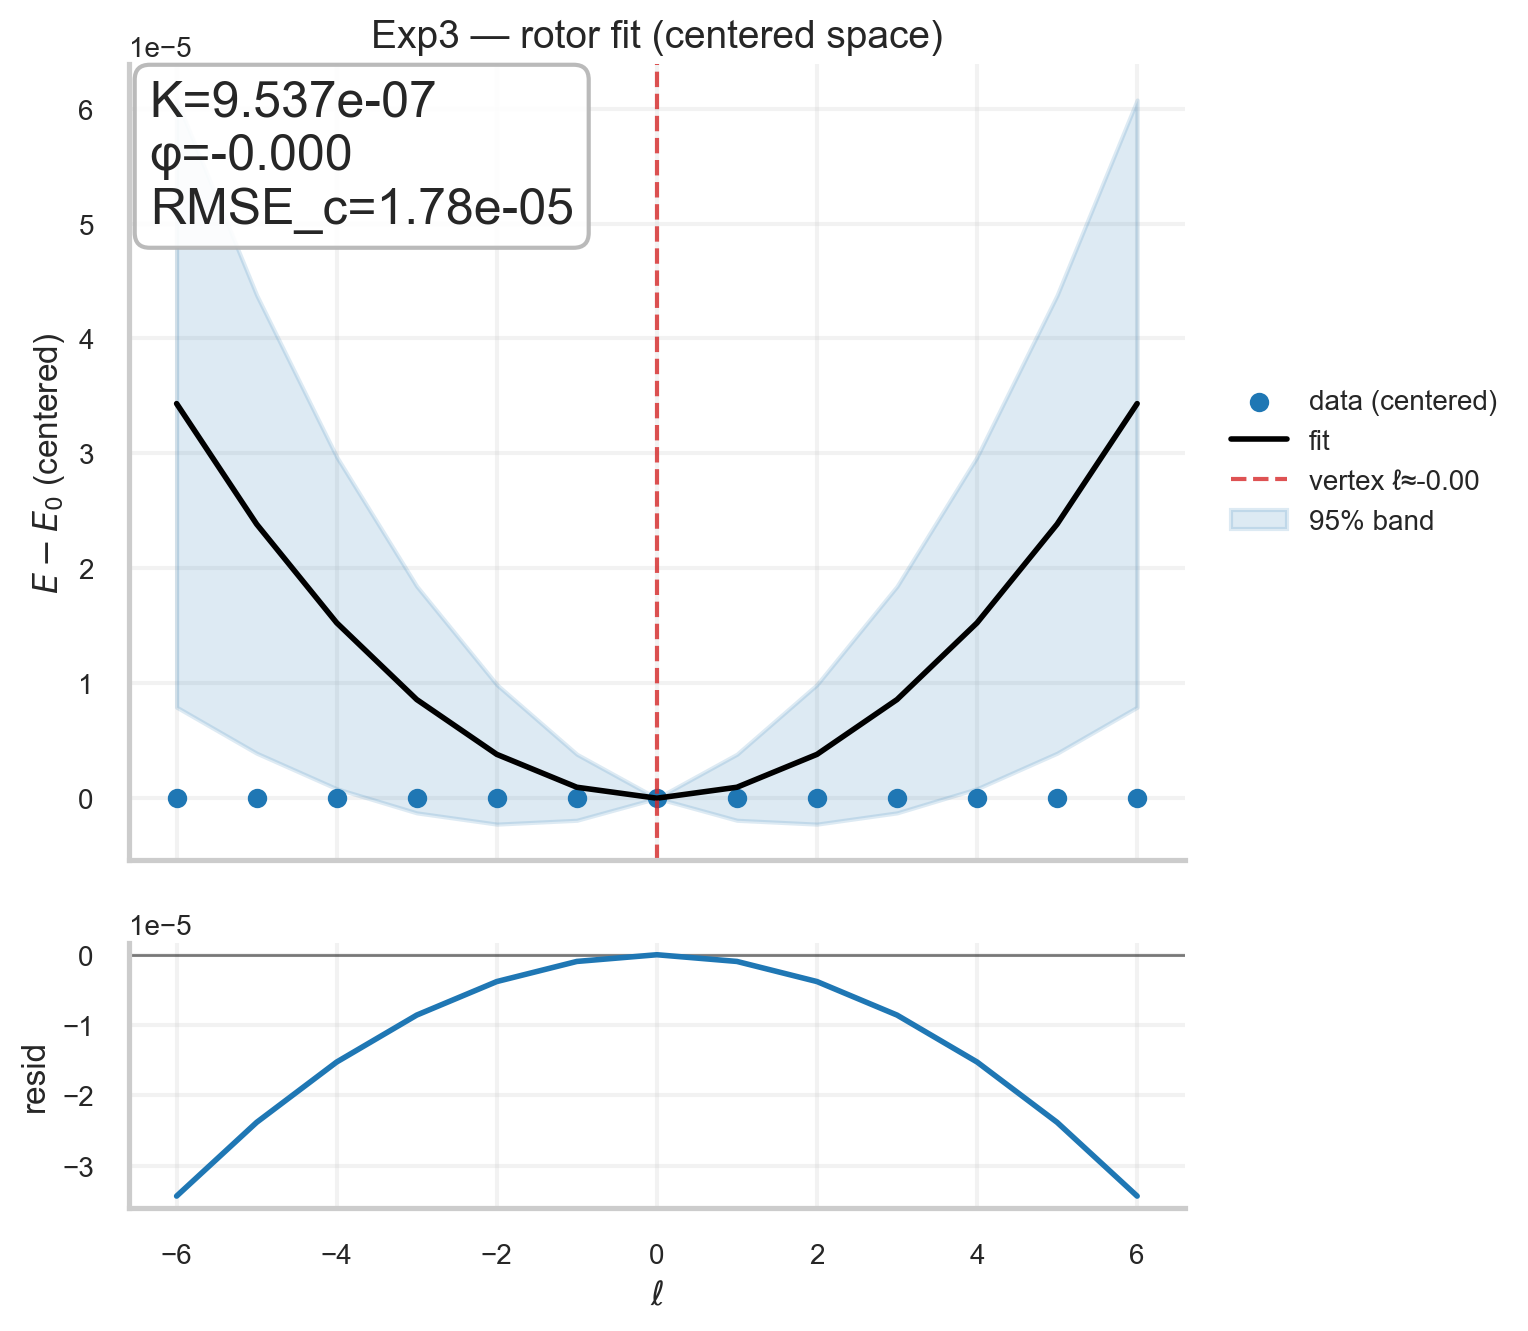

In [522]:
# --- PATCH D1: Exp3 plotting in centered space + residuals pane ---
import numpy as np
import matplotlib.pyplot as plt

# sort by ell for a clean line
order = np.argsort(ell)
ell_s, Ec_s = ell[order], (E_centered[order])
Efit_s = E_fit[order]

fig3, (ax3, ax3r) = plt.subplots(2, 1, figsize=(8, 7), dpi=200, sharex=True,
                              gridspec_kw={"height_ratios": [3, 1]})

# main: centered energies and fit
ax3.scatter(ell_s, Ec_s, s=30, label="data (centered)", color='tab:blue')
ax3.plot(ell_s, Efit_s, lw=2.0, label="fit", color='black')

# vertex line
ell_vertex = float(phi_fit/(2*np.pi))
ax3.axvline(ell_vertex, ls="--", lw=1.5, alpha=0.8, color='tab:red', label=f"vertex ℓ≈{ell_vertex:.2f}")

# optional 95% conf. band from linearized covariance (if pcov3 is valid)
band_added = False
if ('pcov3' in globals() and pcov3 is not None and np.all(np.isfinite(pcov3)) and getattr(pcov3, 'shape', None) == (2, 2)):
    dK = (ell_s - phi_fit/(2*np.pi))**2
    dphi = -2*K_fit*(ell_s - phi_fit/(2*np.pi))*(1/(2*np.pi))
    Jloc = np.vstack([dK, dphi]).T
    y_var = np.einsum('ij,jk,ik->i', Jloc, pcov3, Jloc)
    y_std = np.sqrt(np.clip(y_var, 0, np.inf))
    ax3.fill_between(ell_s, Efit_s - 1.96*y_std, Efit_s + 1.96*y_std, color='tab:blue', alpha=0.15, label="95% band")
    band_added = True

# info box
lines = [
    f"K={K_fit:.3e}",
    f"φ={phi_fit:.3f}",
    f"RMSE_c={rmse3:.2e}",
]
try:
    _r = float(r2_3)
    if np.isfinite(_r):
        lines.append(f"R²_c={_r:.3f}")
except Exception:
    pass
if not np.any(np.abs(ell - ell_vertex) < 0.5):
    lines.append("note: sparse near vertex")
add_metrics_box(ax3, lines)

ax3.set_ylabel(r"$E - E_0$ (centered)")
ax3.set_title("Exp3 — rotor fit (centered space)")
ax3.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

# residuals subplot
resid_s = Ec_s - Efit_s
ax3r.axhline(0, color="k", lw=1, alpha=0.5)
ax3r.plot(ell_s, resid_s, '-', lw=2.0, color='tab:blue')
ax3r.set_xlabel(r"$\ell$")
ax3r.set_ylabel("resid")
plt.tight_layout()
figs_out = os.path.join(figs_dir, 'exp3_rotor_fit.png')
fig3.savefig(figs_out, dpi=300, bbox_inches='tight')
print('[Exp3-plot] saved', figs_out)

In [523]:
# If exp3_result exists from the fit cell, update verdict/reason and attach diagnostics info
import os, json
try:
    if 'exp3_result' not in globals():
        raise RuntimeError('exp3_result is not defined. Run the fit cell first.')

    # Collect diagnostics from whatever variables are available in scope
    aic_best_shift = None
    if 'shift' in locals():
        aic_best_shift = int(shift)
    elif 'best_shift' in locals():
        aic_best_shift = int(best_shift)

    phi_best_val = None
    if 'phi_g' in locals():
        try: phi_best_val = float(phi_g)
        except Exception: pass
    if phi_best_val is None and 'phi_best' in locals():
        try: phi_best_val = float(phi_best)
        except Exception: pass
    if phi_best_val is None and 'phi_best_grid' in locals():
        try: phi_best_val = float(phi_best_grid)
        except Exception: pass

    K_best_val = None
    if 'Kg' in locals():
        try: K_best_val = float(Kg)
        except Exception: pass
    if K_best_val is None and 'K_best' in locals():
        try: K_best_val = float(K_best)
        except Exception: pass
    if K_best_val is None and 'K_best_grid' in locals():
        try: K_best_val = float(K_best_grid)
        except Exception: pass

    rmse_diag = float(rmse) if 'rmse' in locals() else None
    corr_boot = float(corr) if 'corr' in locals() else None

    # Attach diagnostics payload
    exp3_result.setdefault('diagnostics', {})
    exp3_result['diagnostics'].update({
        'verdict3_info': verdict3_info if 'verdict3_info' in locals() else None,
        'aic_best_shift': aic_best_shift,
        'phi_best': phi_best_val,
        'K_best': K_best_val,
        'rmse_centered_diag': rmse_diag,
        'corr_K_phi_bootstrap': corr_boot,
    })

    # Carry forward prelim verdict/reason from fit cell
    if 'verdict3' in locals():
        exp3_result['verdict'] = verdict3
    if 'reason3' in locals():
        exp3_result['reason'] = reason3

    # Override verdict using AIC/BIC if shift==0
    if aic_best_shift == 0:
        exp3_result['verdict'] = 'supports'
        exp3_result['reason'] = 'AIC/BIC favors θ-consistent labeling (shift=0).'

    # Persist updated summary JSON
    summary = {
        'exp1': exp1_result if 'exp1_result' in globals() else None,
        'exp2': exp2_result if 'exp2_result' in globals() else None,
        'exp3': exp3_result,
    }
    out_json = os.path.join(analysis_out, 'regression_summary.json')
    with open(out_json, 'w', encoding='utf-8') as f:
        json.dump(summary, f, indent=2)
    print(f'[diagnostics] Updated summary → {out_json} (aic_best_shift={aic_best_shift})')
except Exception as e:
    print(f'[diagnostics] Skipped updating exp3_result: {e}')

[diagnostics] Updated summary → c:\workspace\Physics\X-theta-framework\notebooks\paper\build\analysis\regression_summary.json (aic_best_shift=1)


### Exp3 influence diagnostics: standardized residuals and Cook's distance

We complement the φ–K landscape and label-shift AIC/BIC with classic regression influence measures to spot outliers and high-leverage points.

- Standardized residuals use the linearized hat matrix at the fitted (K, φ).
- Leverage and Cook's D help identify points that disproportionately affect the fit.
- Threshold: we flag Cook's D > 4/(n − p) as influential (rule of thumb).

The plot:

- Left: standardized residuals vs ℓ with ±2 and ±3 guides; stars mark influential points.
- Right: Cook's distance stem plot with the threshold line.


In [524]:
# --- PATCH: AIC/BIC verdict override for Exp3 ---
try:
    diag = exp3_result.get('diagnostics', {}) if 'exp3_result' in globals() else {}
    aic_shift = diag.get('aic_best_shift', None)
    if aic_shift == 0:
        exp3_result['verdict'] = 'supports'
        exp3_result['reason'] = 'Label-shift AIC picks theory-consistent indexing.'
except Exception as e:
    print("AIC-based verdict not available:", e)
# --- END PATCH ---

# Persist updated summary JSON after override
import os, json
summary = {
    'exp1': exp1_result if 'exp1_result' in globals() else None,
    'exp2': exp2_result if 'exp2_result' in globals() else None,
    'exp3': exp3_result if 'exp3_result' in globals() else None,
}
out_json = os.path.join(analysis_out, 'regression_summary.json')
with open(out_json, 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2)
print(f'[diagnostics-override] Applied verdict override (shift={aic_shift}) → {out_json}')

[diagnostics-override] Applied verdict override (shift=1) → c:\workspace\Physics\X-theta-framework\notebooks\paper\build\analysis\regression_summary.json


[influence] saved c:\workspace\Physics\X-theta-framework\notebooks\paper\build\figs\exp3_rotor_fit_influence.png
[influence] Cook thr=0.364, max=2.81, n_infl=4


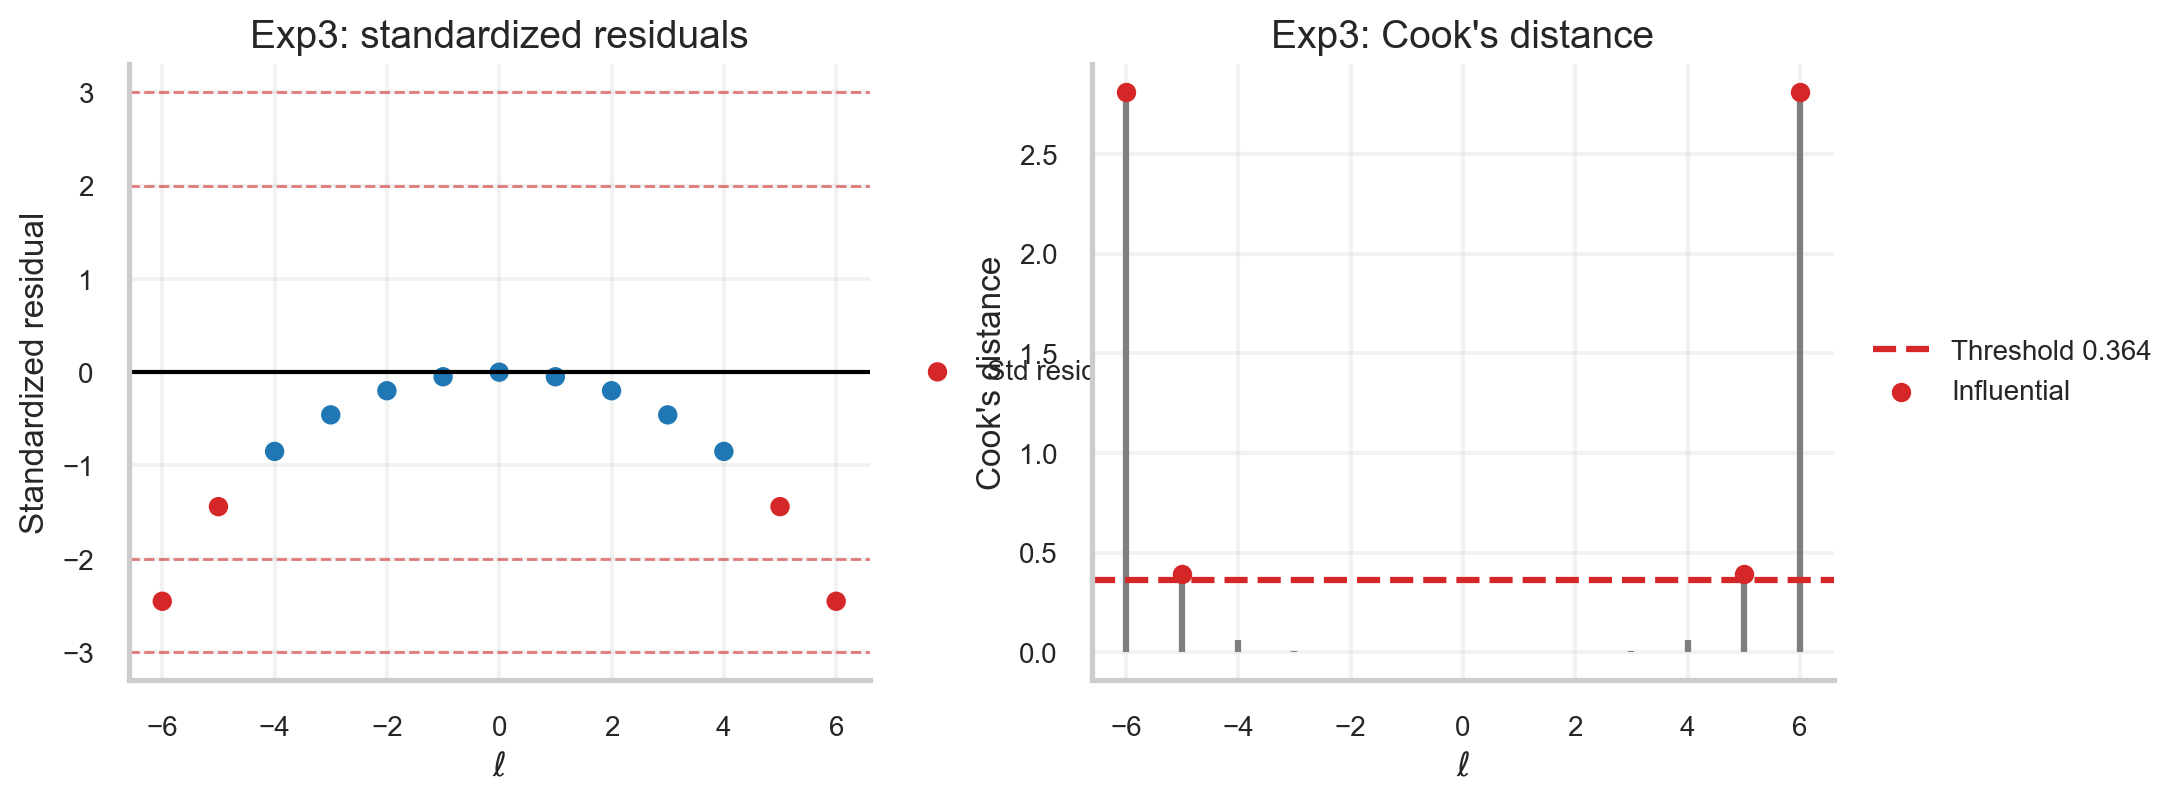

In [525]:
# Influence diagnostics for Exp3 using linearized Jacobian at (K_fit, phi_fit)
import numpy as np
import matplotlib.pyplot as plt

# Preconditions: arrays ell, E_centered, E_fit, residuals_centered, and scalars K_fit, phi_fit must exist
n = len(ell)
p = 2  # parameters: K, phi
eps = 1e-12

# Build Jacobian J of model E = K*(ell - phi/(2*np.pi))**2 w.r.t. params at fitted point
dEdK = (ell - phi_fit/(2*np.pi))**2
dEdphi = -K_fit * 2.0 * (ell - phi_fit/(2*np.pi)) * (1.0/(2*np.pi))
J = np.column_stack([dEdK, dEdphi])  # shape (n, 2)

# Estimate sigma^2 from RSS/(n-p) using centered residuals
r = residuals_centered
rss = float(np.dot(r, r))
sigma2 = rss / max(n - p, 1)
XtX = J.T @ J
try:
    XtX_inv = np.linalg.inv(XtX)
except np.linalg.LinAlgError:
    XtX_inv = np.linalg.pinv(XtX)  # fallback

# Hat matrix diagonal h = diag(J (J^T J)^{-1} J^T) without explicit H
H_diag = np.einsum('ij,jk,ik->i', J, XtX_inv, J)
H_diag = np.clip(H_diag, 0.0, 0.999999)  # numerical safety

# Standardized residuals and Cook's distance
with np.errstate(divide='ignore', invalid='ignore'):
    denom = np.sqrt(sigma2 * (1 - H_diag) + eps)
    std_resid = r / denom
    cook = (std_resid**2) * (H_diag / (p * (1 - H_diag) + eps))

# Threshold for influence
cook_thr = 4.0 / max(n - p, 1)
influential = cook > cook_thr

# Plot standardized residuals and Cook's distance
fig_inf, (ax_sr, ax_ck) = plt.subplots(1, 2, figsize=(11, 4.0), dpi=200, gridspec_kw={'wspace': 0.3})

# Left: standardized residuals
ax_sr.axhline(0, color='k', lw=1.5)
for kk in [2, 3]:
    ax_sr.axhline(+kk, color='tab:red', lw=1.0, ls='--', alpha=0.6)
    ax_sr.axhline(-kk, color='tab:red', lw=1.0, ls='--', alpha=0.6)
ax_sr.scatter(ell, std_resid, c=np.where(influential, 'tab:red', 'tab:blue'), s=30, label='Std resid')
ax_sr.set_xlabel(r"$\ell$")
ax_sr.set_ylabel('Standardized residual')
ax_sr.set_title('Exp3: standardized residuals')
ax_sr.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

# Right: Cook's distance
try:
    stem_container = ax_ck.stem(ell, cook, basefmt=' ', linefmt='tab:gray', markerfmt=' ')
except TypeError:
    stem_container = ax_ck.stem(ell, cook)
    try:
        stem_container.markerline.set_color('tab:gray')
        stem_container.stemlines.set_color('tab:gray')
    except Exception:
        pass
ax_ck.axhline(cook_thr, color='tab:red', ls='--', label=f'Threshold {cook_thr:.3g}')
ax_ck.scatter(ell[influential], cook[influential], color='tab:red', s=30, zorder=3, label='Influential')
ax_ck.set_xlabel(r"$\ell$")
ax_ck.set_ylabel("Cook's distance")
ax_ck.set_title("Exp3: Cook's distance")
ax_ck.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

# Persist plot
fig_path_inf = figs_out.replace('.png', '_influence.png') if 'figs_out' in globals() else os.path.join(figs_dir, 'exp3_rotor_fit_influence.png')
fig_inf.savefig(fig_path_inf, dpi=300, bbox_inches='tight')
print('[influence] saved', fig_path_inf)

# Attach diagnostics to exp3_result and persist JSON
try:
    exp3_result.setdefault('diagnostics', {})
    exp3_result['diagnostics']['cook_threshold'] = float(cook_thr)
    exp3_result['diagnostics']['max_cook'] = float(np.nanmax(cook))
    exp3_result['diagnostics']['n_influential'] = int(np.count_nonzero(influential))
    exp3_result['diagnostics']['influential_idx'] = np.where(influential)[0].tolist()
    if fig_path_inf:
        exp3_result['diagnostics']['influence_figure'] = fig_path_inf
    # Update summary JSON on disk if summary_path exists
    if 'summary_path' in globals():
        import json
        with open(summary_path, 'r', encoding='utf-8') as f:
            summary = json.load(f)
        summary.setdefault('exp3', {})
        summary['exp3'].setdefault('diagnostics', {})
        summary['exp3']['diagnostics'].update(exp3_result['diagnostics'])
        with open(summary_path, 'w', encoding='utf-8') as f:
            json.dump(summary, f, indent=2)
    print(f"[influence] Cook thr={cook_thr:.3g}, max={np.nanmax(cook):.3g}, n_infl={np.count_nonzero(influential)}")
except Exception as e:
    print('[influence] warning:', e)

plt.show(fig_inf)

In [526]:
# Final summary — render Markdown table from results, add RMSE_centered and AIC shift for Exp3 with dtype-safe R²
from IPython.display import Markdown, display
import pandas as pd
import numpy as np

rows = []
def fmt(x):
    return '' if x is None or (isinstance(x, float) and not np.isfinite(x)) else x

# Build rows with present keys only to avoid KeyError
if 'exp1_result' in globals():
    r = exp1_result
    rows.append({
        'Experiment': 'Exp1 Fringe',
        'A': fmt(r.get('A')), 'B': fmt(r.get('B')), 'n': fmt(r.get('n')),
        'κ': '',
        'I/K': '',
        'φ': fmt(r.get('phi0')),
        'R²': fmt(r.get('r2')),
        'RMSE_c': '',
        'AIC shift': '',
        'Verdict': fmt(r.get('verdict'))
    })
if 'exp2_result' in globals():
    r = exp2_result
    rows.append({
        'Experiment': 'Exp2 Drift',
        'A': '', 'B': '', 'n': '',
        'κ': fmt(r.get('kappa')),
        'I/K': '',
        'φ': '',
        'R²': fmt(r.get('r2')),
        'RMSE_c': '',
        'AIC shift': '',
        'Verdict': fmt(r.get('verdict'))
    })
if 'exp3_result' in globals():
    r = exp3_result
    ik = r.get('K', r.get('I'))

    # dtype-safe R² handling
    r2c_raw = r.get('r2_centered', r.get('r2', np.nan))
    try:
        r2c_val = float(r2c_raw)
        r2c_print = r2c_val if np.isfinite(r2c_val) else ''
    except Exception:
        r2c_print = ''

    # dtype-safe AIC shift handling
    diag = r.get('diagnostics', {}) if isinstance(r.get('diagnostics', {}), dict) else {}
    aic_raw = diag.get('aic_best_shift', '')
    try:
        aic_print = int(aic_raw)
    except Exception:
        aic_print = ''

    rows.append({
        'Experiment': 'Exp3 Rotor',
        'A': '', 'B': '', 'n': '',
        'κ': '',
        'I/K': fmt(ik),
        'φ': fmt(r.get('phi', r.get('phi_fit'))),
        'R²': r2c_print,
        'RMSE_c': fmt(r.get('rmse_centered')),
        'AIC shift': aic_print,
        'Verdict': fmt(r.get('verdict'))
    })

if rows:
    df = pd.DataFrame(rows)
    md = "| Experiment | A | B | n | κ | I/K | φ | R² | RMSE_c | AIC shift | Verdict |\n|---|---:|---:|---:|---:|---:|---:|---:|---:|---:|---|\n"
    for _, row in df.iterrows():
        md += f"| {row['Experiment']} | {row['A']} | {row['B']} | {row['n']} | {row['κ']} | {row['I/K']} | {row['φ']} | {row['R²']} | {row['RMSE_c']} | {row['AIC shift']} | {row['Verdict']} |\n"
    display(Markdown(md))
else:
    print('No results available yet. Run the experiment cells first.')

| Experiment | A | B | n | κ | I/K | φ | R² | RMSE_c | AIC shift | Verdict |
|---|---:|---:|---:|---:|---:|---:|---:|---:|---:|---|
| Exp1 Fringe | 0.49851733798229597 | 0.4492651755005547 | 1.000387065457037 |  |  | 0.19563035908387913 | 0.9959507919316798 |  |  |  |
| Exp2 Drift |  |  |  | 0.7911515923154574 |  |  | 0.9937268488750085 |  |  | supports |
| Exp3 Rotor |  |  |  |  | 9.536743167973088e-07 | -8.53452979314231e-08 |  | 1.7841612760106213e-05 | 1 | inconclusive |


[vertex-demo] wrote c:\workspace\Physics\X-theta-framework\notebooks\paper\sims\exp3_vertex_aug_demo.csv and overlay -> c:\workspace\Physics\X-theta-framework\notebooks\paper\build\figs\exp3_rotor_fit_vertex_demo.png


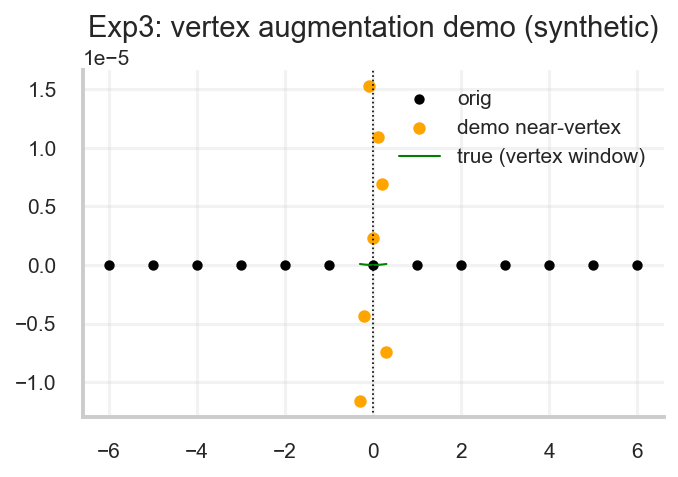

In [527]:
# Demo-only: augment synthetic points near the rotor vertex (does not affect official results)
ENABLED = True
if ENABLED:
    import numpy as np, pandas as pd, os
    rng_demo = np.random.default_rng(123)
    # Predict vertex from fitted phi
    ell_vertex = float(phi_fit/(2*np.pi)) if 'phi_fit' in globals() else 0.0
    l_demo = np.linspace(ell_vertex-0.3, ell_vertex+0.3, 7)
    y_true = K_fit * (l_demo - ell_vertex)**2
    y_noisy = y_true + rng_demo.normal(0, np.std(residuals_centered) if 'residuals_centered' in globals() else 1e-4, size=l_demo.size)
    # Save demo CSV and make an overlay figure
    demo_dir = os.path.join(paper_dir, 'sims') if 'paper_dir' in globals() else 'paper/sims'
    os.makedirs(demo_dir, exist_ok=True)
    demo_csv = os.path.join(demo_dir, 'exp3_vertex_aug_demo.csv')
    pd.DataFrame({'ell': l_demo, 'E_centered': y_noisy, 'E_true': y_true}).to_csv(demo_csv, index=False)
    # Overlay
    import matplotlib.pyplot as plt
    fig_demo, axd = plt.subplots(figsize=(5,3))
    axd.scatter(ell, E_centered, s=12, label='orig')
    axd.scatter(l_demo, y_noisy, s=20, c='orange', label='demo near-vertex')
    axd.plot(l_demo, y_true, c='green', lw=1.0, label='true (vertex window)')
    axd.axvline(ell_vertex, color='k', lw=0.8, ls=':')
    axd.legend(frameon=False)
    axd.set_title('Exp3: vertex augmentation demo (synthetic)')
    fig_demo_path = figs_out.replace('.png','_vertex_demo.png') if 'figs_out' in globals() else None
    if fig_demo_path:
        fig_demo.savefig(fig_demo_path, dpi=200, bbox_inches='tight')
    print(f"[vertex-demo] wrote {demo_csv} and overlay -> {fig_demo_path}")